In [ ]:
##!/usr/bin/env python
"""plot_East_West_comparison.py

Script plots the point time series against AWS data to evaluate model data at different lat/lon locations
to understand the contrast across the city

Author: Annette L Hirsch @ CLEX, UNSW. Sydney (Australia)
email: a.hirsch@unsw.edu.au
Created: Thu Jul 30 14:26:12 AEST 2020

"""

In [1]:
import warnings
warnings.filterwarnings("ignore")

Load Packages

In [2]:
#from __future__ import division
import numpy as np
import pandas as pd
import math
import netCDF4 as nc
import sys
import os
import glob as glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
from matplotlib.collections import LineCollection
import common_functions as cf
import datetime as dt
import wrf
from scipy import stats


## Model Data

In [3]:
# Simulation Period
syear = 2017
smon = 1
sday = 2 
eyear = 2017
emon = 2
eday = 28  # Add an extra day so that the 27th Feb data is included
simlen = dt.datetime(eyear,emon,eday) - dt.datetime(syear,smon,sday)
nst = (simlen.days * 24 * 6) # No. simulations days x 24 hours in a day x 6 history intervals per hour

# Dates - Used for subsetting the AWS data so you pick the day before the start date and the day after the end date
sdate = "2017-01-01"
edate = "2017-02-28"

# Data directory 
datadir='/g/data/w97/azh561/WRF/'
ensmem = ['sydney800m','sydney800m_06H','sydney800m_12H','sydney800m_18H','sydney800m_00H']
rlabels = ['U1','U2','U3','U4','U5']
domain = ["d02","d02","d02","d02","d02"]
nmem = len(ensmem)

# Landsea mask
mask_file='/g/data/w97/azh561/WRF/sydney800m_06H/geo_em.%s.nc' %(domain[0])
f = nc.Dataset(mask_file)
lu = f.variables['LU_INDEX'][0,:,:]
lat2d = f.variables['XLAT_M'][0,:,:]
lontmp = f.variables['XLONG_M'][0,:,:]
lon2d = np.where(lontmp<0.0,lontmp+360,lontmp)
clon = f.getncattr('CEN_LON')
nlu = f.getncattr('NUM_LAND_CAT')
iswater = f.getncattr('ISWATER')
f.close()

print("Domain %s Lat: %s to %s Lon: %s to %s" %(domain[0],np.nanmin(lat2d),np.nanmax(lat2d),np.nanmin(lon2d),np.nanmax(lon2d)))

# Figure Details
fig_dir='%s/figures/' %(os.getcwd())
fig_name_prefix='AWS_comparison_'
if not os.path.exists(fig_dir):
  os.makedirs(fig_dir)


Domain d02 Lat: -35.119434 to -32.14975 Lon: 148.70343 to 152.65186


In [4]:
start = dt.datetime(syear,smon,sday,0,0,0)
end = dt.datetime(eyear,emon,eday,0,0,0)
days = (end - start).days
ntim = days * 24 * 60
datelist = [start + dt.timedelta(minutes=x) for x in range(ntim+1)]
# Get the day-month hour-minutes on 10 minute interval
ftimes = np.asarray([datelist[x].strftime("%m-%d %H-%M") for x in range(ntim+1)])[::10]
fdates = np.asarray([datelist[x].strftime("%m-%d") for x in range(ntim+1)])[::10]
fhours = np.asarray([datelist[x].strftime("%H") for x in range(ntim+1)])[::10]

In [5]:
HW1S = [i for i in range(len(ftimes)) if ftimes[i] in ['01-11 00-00']][0]
HW1F = [i for i in range(len(ftimes)) if ftimes[i] in ['01-14 12-00']][0]

HW2S = [i for i in range(len(ftimes)) if ftimes[i] in ['01-16 00-00']][0]
HW2F = [i for i in range(len(ftimes)) if ftimes[i] in ['01-18 12-00']][0]

HW3S = [i for i in range(len(ftimes)) if ftimes[i] in ['01-30 00-00']][0]
HW3F = [i for i in range(len(ftimes)) if ftimes[i] in ['02-01 12-00']][0]

HW4S = [i for i in range(len(ftimes)) if ftimes[i] in ['02-05 00-00']][0]
HW4F = [i for i in range(len(ftimes)) if ftimes[i] in ['02-07 12-00']][0]

HW5S = [i for i in range(len(ftimes)) if ftimes[i] in ['02-10 00-00']][0]
HW5F = [i for i in range(len(ftimes)) if ftimes[i] in ['02-12 12-00']][0]

In [6]:
# Function to plot data
def plot_ts(time,tsdata,tind,vlabels,llabel,figurename,lspace):

    """This function plots time series for observations and models"""

    from matplotlib.colors import BoundaryNorm
    from matplotlib.ticker import MaxNLocator
    import string
    import scipy
    
    # Figure formatting
    plt.rcParams['savefig.dpi']=300
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["font.size"] = 18

    # Define dimensions
    nmod = tsdata.shape[0]
    nvar = tsdata.shape[1]
    nt = tsdata.shape[2]
      
    # Create figure object and subplots
    fig, ax = plt.subplots(nvar, 1, figsize=(30.0,5.0*(nvar)), squeeze=False)
    tarr = np.arange(0,nt)
    evenly_spaced_interval = np.linspace(0, 1, nmod)
    mycolors = ['blue','red','black','grey'] #[plt.cm.rainbow(x) for x in evenly_spaced_interval]
    
    # Iterate through variables
    for vind in range(nvar):

        for mm in range(nmod):
            ax[vind,0].plot(tarr,tsdata[mm,vind,:], linewidth=2,color=mycolors[mm], linestyle='-',label=llabel[mm])

#        if vind in [2]: #> 1:
#            d = scipy.zeros(len(tsdata[vind,:]))
#            ax[vind,0].fill_between(tarr,tsdata[vind,:], where=tsdata[vind,:]>=d, interpolate=True, alpha=0.5, color='red')
#            ax[vind,0].fill_between(tarr,tsdata[vind,:], where=tsdata[vind,:]<=d, interpolate=True, alpha=0.5, color='blue')
#        if vind in [3]: #> 1:
#            d = scipy.zeros(len(tsdata[vind,:]))
#            ax[vind,0].fill_between(tarr,tsdata[vind,:], where=tsdata[vind,:]>=d, interpolate=True, alpha=0.5, color='blue')
#            ax[vind,0].fill_between(tarr,tsdata[vind,:], where=tsdata[vind,:]<=d, interpolate=True, alpha=0.5, color='red')
       
        # Fix Labelling
        ax[vind,0].set_ylabel('%s' %(vlabels[vind]), fontweight = 'bold',fontsize=18)
        ax[vind,0].set_title('(%s)' %(string.ascii_lowercase[vind]), fontweight='bold', fontsize=18, y = 0.9, x = 0.015)
 
        # Amend axis limits
        ax[vind,0].set_xlim(tarr[0],tarr[-1])
        
        if vind < nvar-1:
            ax[vind,0].set_xticks([],[])
        else:
            ax[vind,0].set_xticks(tarr[::lspace])
            ax[vind,0].set_xticklabels(time[::lspace],rotation=90,fontsize=18)

        # Add vertical line at dates of interest
        #for ll in range(len(tind)): 
        #    ax[vind,0].axvline(tind[ll], color='grey', linestyle='--',linewidth=3.0)
        ax[vind,0].axvspan(tind[0], tind[1], alpha=0.25, color='red')
        ax[vind,0].axvspan(tind[2], tind[3], alpha=0.25, color='red')
        ax[vind,0].axvspan(tind[4], tind[5], alpha=0.25, color='red')
        ax[vind,0].axvspan(tind[6], tind[7], alpha=0.25, color='red')
        ax[vind,0].axvspan(tind[8], tind[9], alpha=0.25, color='red')

    # Add text to label the heatwaves above the first plot
    ax[0,0].text(0.1875,1.05,'%s HW' %('$1^{st}$'), 
                            horizontalalignment='center',verticalalignment='center',transform = ax[0,0].transAxes,
                            color='black', fontweight='bold', fontsize=18)
    ax[0,0].text(0.265,1.05,'%s HW' %('$2^{nd}$'), 
                            horizontalalignment='center',verticalalignment='center',transform = ax[0,0].transAxes,
                            color='black', fontweight='bold', fontsize=18)
    ax[0,0].text(0.515,1.05,'%s HW' %('$3^{rd}$'), 
                            horizontalalignment='center',verticalalignment='center',transform = ax[0,0].transAxes,
                            color='black', fontweight='bold', fontsize=18)
    ax[0,0].text(0.62,1.05,'%s HW' %('$4^{th}$'), 
                            horizontalalignment='center',verticalalignment='center',transform = ax[0,0].transAxes,
                            color='black', fontweight='bold', fontsize=18)
    ax[0,0].text(0.705,1.05,'%s HW' %('$5^{th}$'), 
                            horizontalalignment='center',verticalalignment='center',transform = ax[0,0].transAxes,
                            color='black', fontweight='bold', fontsize=18)
                 
    ax[-2,0].axhline(0., color='grey', linestyle='--',linewidth=3.0)
    ax[-1,0].axhline(0., color='grey', linestyle='--',linewidth=3.0)

    
    legend = ax[-1,0].legend(loc='upper center', bbox_to_anchor=(0.5,-0.2), ncol=nmod, fontsize=14)
#    fig.subplots_adjust(wspace=0.30, hspace=0)
    
    fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.savefig(figurename, bbox_extra_artists=(legend,),bbox_inches='tight')
#    plt.close(fig)


In [7]:
# Define function to smooth the timeseries
# Taken from http://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """
    
    if x.ndim != 1:
        sys.exit("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        sys.ext("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        sys.exit("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


## AWS Data

Data Attributes

In [8]:
awsdir = '/g/data/w97/azh561/WRF/obs/AWS_1mindata_20stations'
awsnum = ['066037','066137','067119','067108']
awsnm = ['Sydney Airport','Bankstown Airport','Horsley Park','Badgerys Creek']
awslat = [-33.9465,-33.9176,-33.851,-33.8969]
awslon = [151.1731,150.9837,150.8567,150.7281]
naws = len(awsnum)

Function to note the bad quality observations

In [9]:
def get_bad_values(data):
    
    # https://stackoverflow.com/questions/19909167/how-to-find-most-frequent-string-element-in-numpy-ndarray
    unique,pos = np.unique(data,return_inverse=True)
    counts = np.bincount(pos)
    maxpos = counts.argmax() # To find the positions of the max count
    
    if unique[maxpos] in ['Y'] and counts[maxpos] == 10:
        qcflag = np.nan
    else:
        qcflag = 0.05
        
    return qcflag

Function to calculate the 10 minute average

In [10]:
def calc_10min_avg(dataframe):
    
    # Variables of interest
    otc = dataframe['tc']
    orh = dataframe['rh']
    owspd = dataframe['wspd']
    owdir = dataframe['wdir']

    # Calculate the 10-minute averages - NOT THE MOST EFFICIENT WAY I'M SURE OF IT!
    odata = np.empty((4,nst),dtype=np.float64)
    for tt in range(nst):

        # T2
        odata[0,tt] = np.mean([float(otc.iloc[(tt*10)]),float(otc.iloc[(tt*10)+1]),float(otc.iloc[(tt*10)+2]),
             float(otc.iloc[(tt*10)+3]),float(otc.iloc[(tt*10)+4]),float(otc.iloc[(tt*10)+5]),
             float(otc.iloc[(tt*10)+6]),float(otc.iloc[(tt*10)+7]),float(otc.iloc[(tt*10)+8]),
             float(otc.iloc[(tt*10)+9])])
        # RH2
        odata[1,tt] = np.mean([float(orh.iloc[(tt*10)]),float(orh.iloc[(tt*10)+1]),float(orh.iloc[(tt*10)+2]),
             float(orh.iloc[(tt*10)+3]),float(orh.iloc[(tt*10)+4]),float(orh.iloc[(tt*10)+5]),
             float(orh.iloc[(tt*10)+6]),float(orh.iloc[(tt*10)+7]),float(orh.iloc[(tt*10)+8]),
             float(orh.iloc[(tt*10)+9])])
        # Wind Speed
        wspd = np.mean([float(owspd.iloc[(tt*10)]),float(owspd.iloc[(tt*10)+1]),float(owspd.iloc[(tt*10)+2]),
             float(owspd.iloc[(tt*10)+3]),float(owspd.iloc[(tt*10)+4]),float(owspd.iloc[(tt*10)+5]),
             float(owspd.iloc[(tt*10)+6]),float(owspd.iloc[(tt*10)+7]),float(owspd.iloc[(tt*10)+8]),
             float(owspd.iloc[(tt*10)+9])])
        # Wind Dir
        wdir = np.mean([float(owdir.iloc[(tt*10)]),float(owdir.iloc[(tt*10)+1]),float(owdir.iloc[(tt*10)+2]),
             float(owdir.iloc[(tt*10)+3]),float(owdir.iloc[(tt*10)+4]),float(owdir.iloc[(tt*10)+5]),
             float(owdir.iloc[(tt*10)+6]),float(owdir.iloc[(tt*10)+7]),float(owdir.iloc[(tt*10)+8]),
             float(owdir.iloc[(tt*10)+9])])

        # U and V wind component
        odata[2,tt] = (wspd*(-1)) * math.sin(math.radians(wdir))
        odata[3,tt] = (wspd*(-1)) * math.cos(math.radians(wdir))
        
        del wspd,wdir

    return odata

Read data and calculate the 10-minute averages

In [11]:
odata = np.empty((naws,4,nst),dtype=np.float64)
oqc = np.empty((naws,4,nst),dtype=np.float64)
for ss in range(naws):
    
    # Read data
    file = "%s/HD01D_Data_%s_46163679534753.txt" %(awsdir,awsnum[ss])
    data = pd.read_csv(file)
    # MUST USE THE UTC TIME SO THAT WRF AND AWS DATA TIMES ARE THE SAME
    data.columns = ["a","No","b","c","d","e","f","g","h","i","j","k","year","month","day","hour","minute",
                "pr","pr_qc","l","tc","tc_qc","wbt","wbt_qc","dp","dp_qc","rh","rh_qc","vp","vp_qc",
                "svp","svp_qc","wspd","wspd_qc","wdir","wdir_qc","m","n","o","p","vis","vis_qc","mslp","mslp_qc","q"]

    data['date'] = pd.to_datetime(data[['year','month','day']])
    data['time'] = pd.to_datetime(data[['year','month','day','hour','minute']])

    # Clip to period of interest
    date_filter = data.loc[(data['date'] > sdate) & (data['date'] < edate)]

    # Deal with empty cells
    date_filter = date_filter.replace(r'^\s*$', np.nan, regex=True)

    # Calculate the 10 minute averages
    odata[ss,:,:] = calc_10min_avg(date_filter)
    
    del data,date_filter

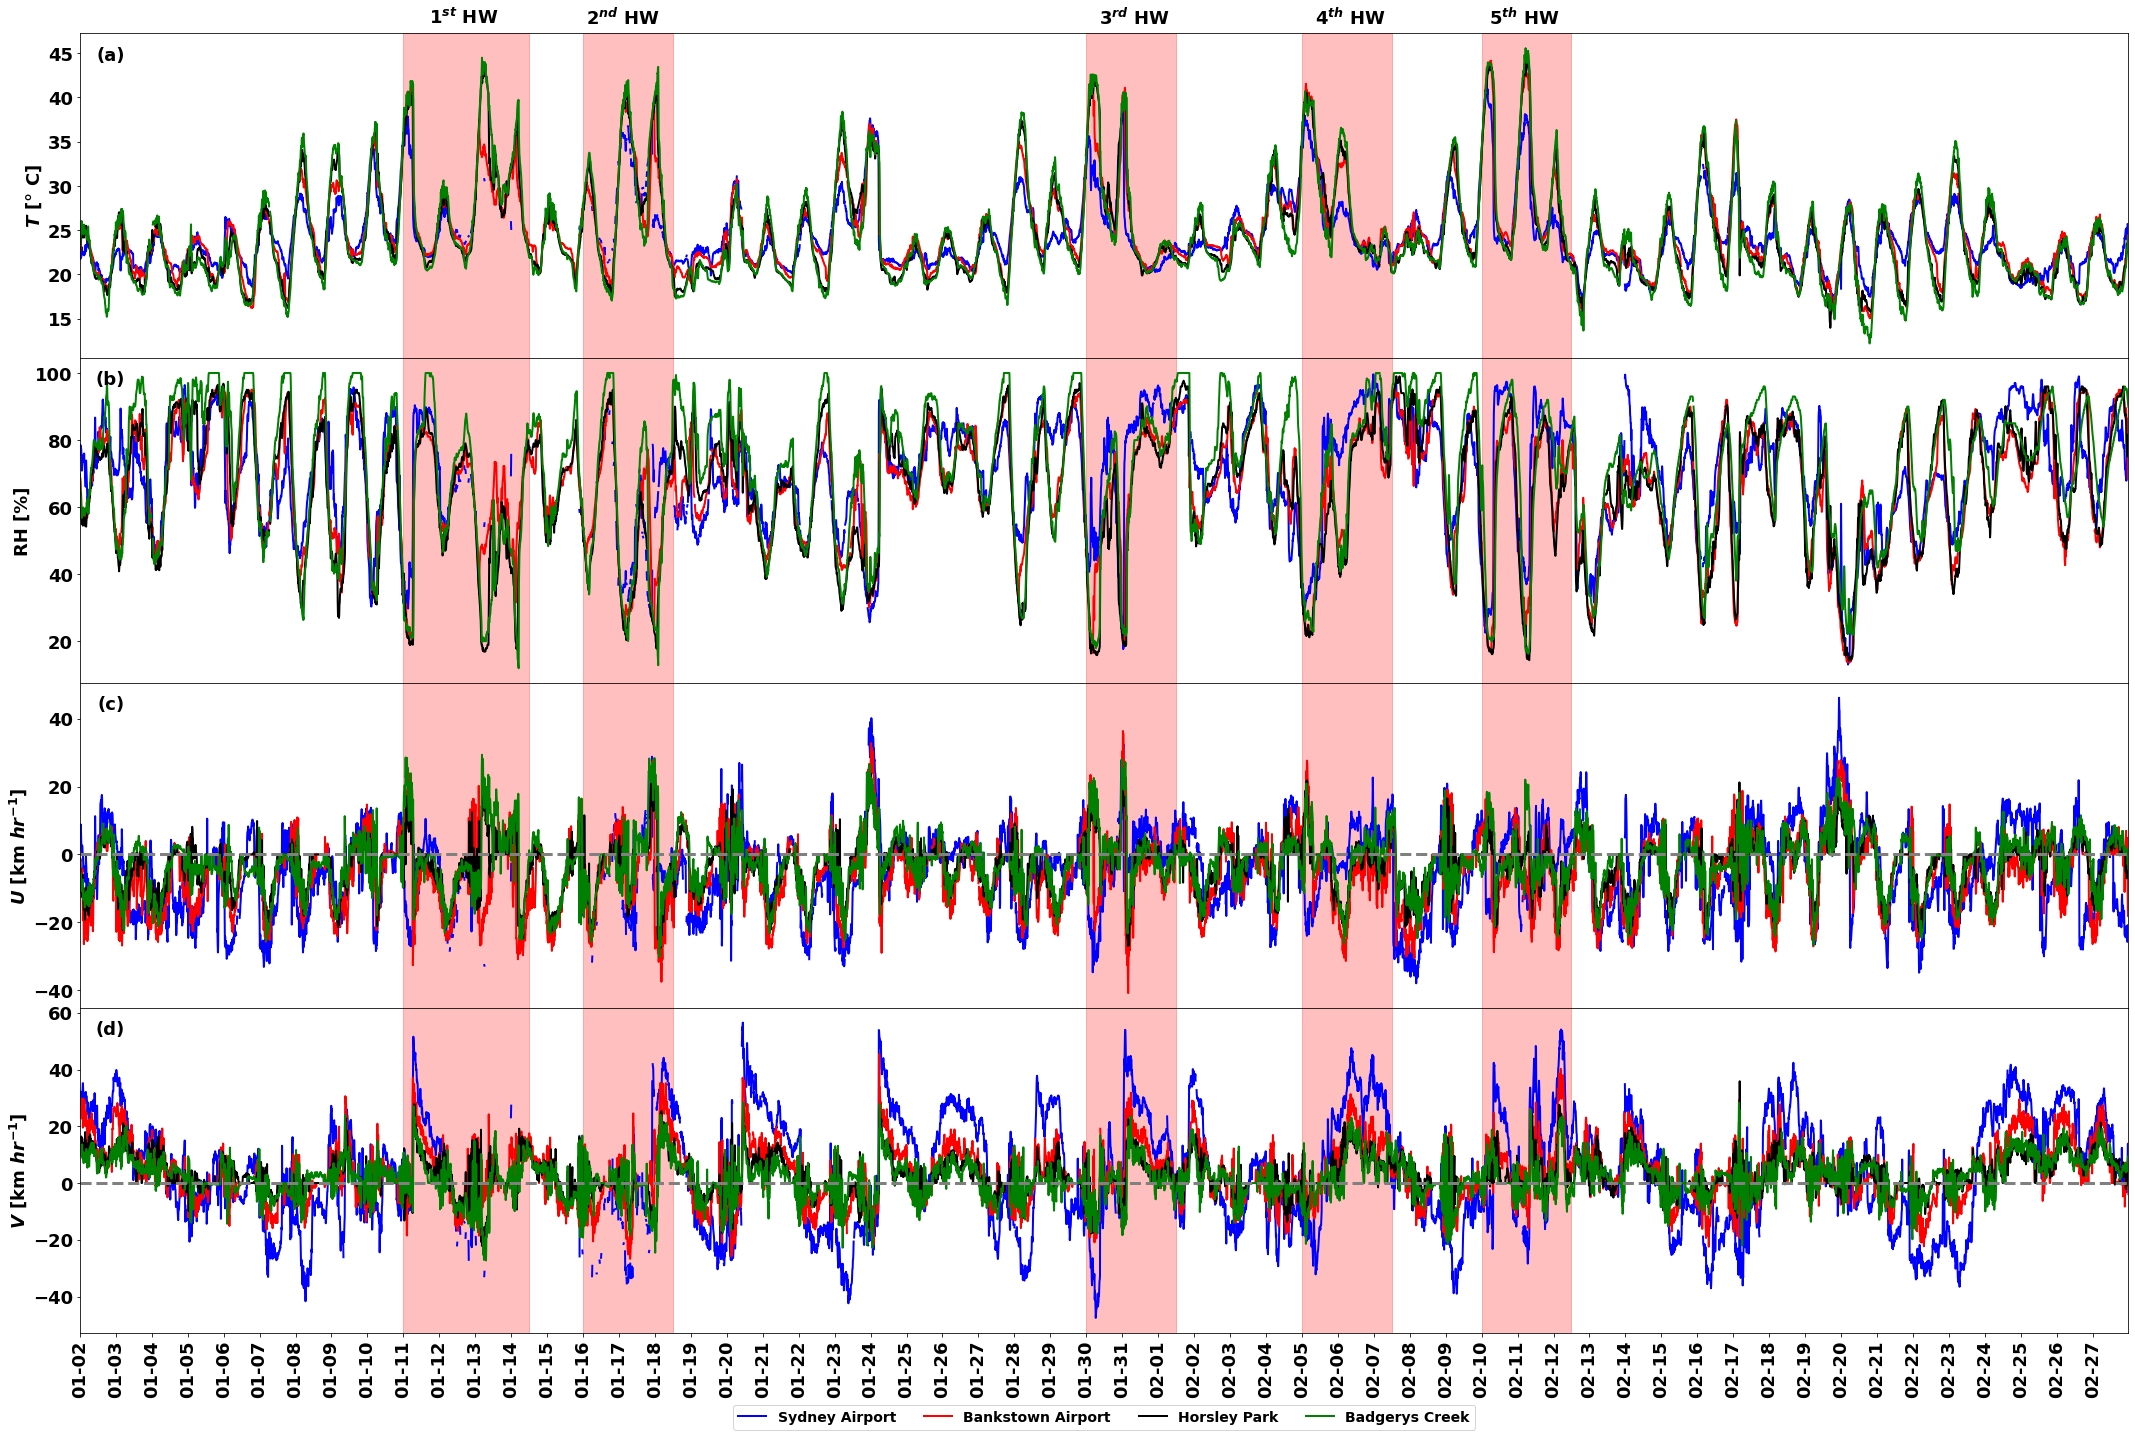

In [16]:
tind = [HW1S,HW1F,HW2S,HW2F,HW3S,HW3F,HW4S,HW4F,HW5S,HW5F]
vlabels = ['$T$ [\xb0 C]','RH [%]','$U$ [km $hr^{-1}$]','$V$ [km $hr^{-1}$]']
lspace = 144 # As the wrf output is saved at a 10 minute interval
figurename = 'AWS_Times_Series_SB_Foehn.png'

plot_ts(fdates[:-1],odata,tind,vlabels,awsnm,figurename,lspace)

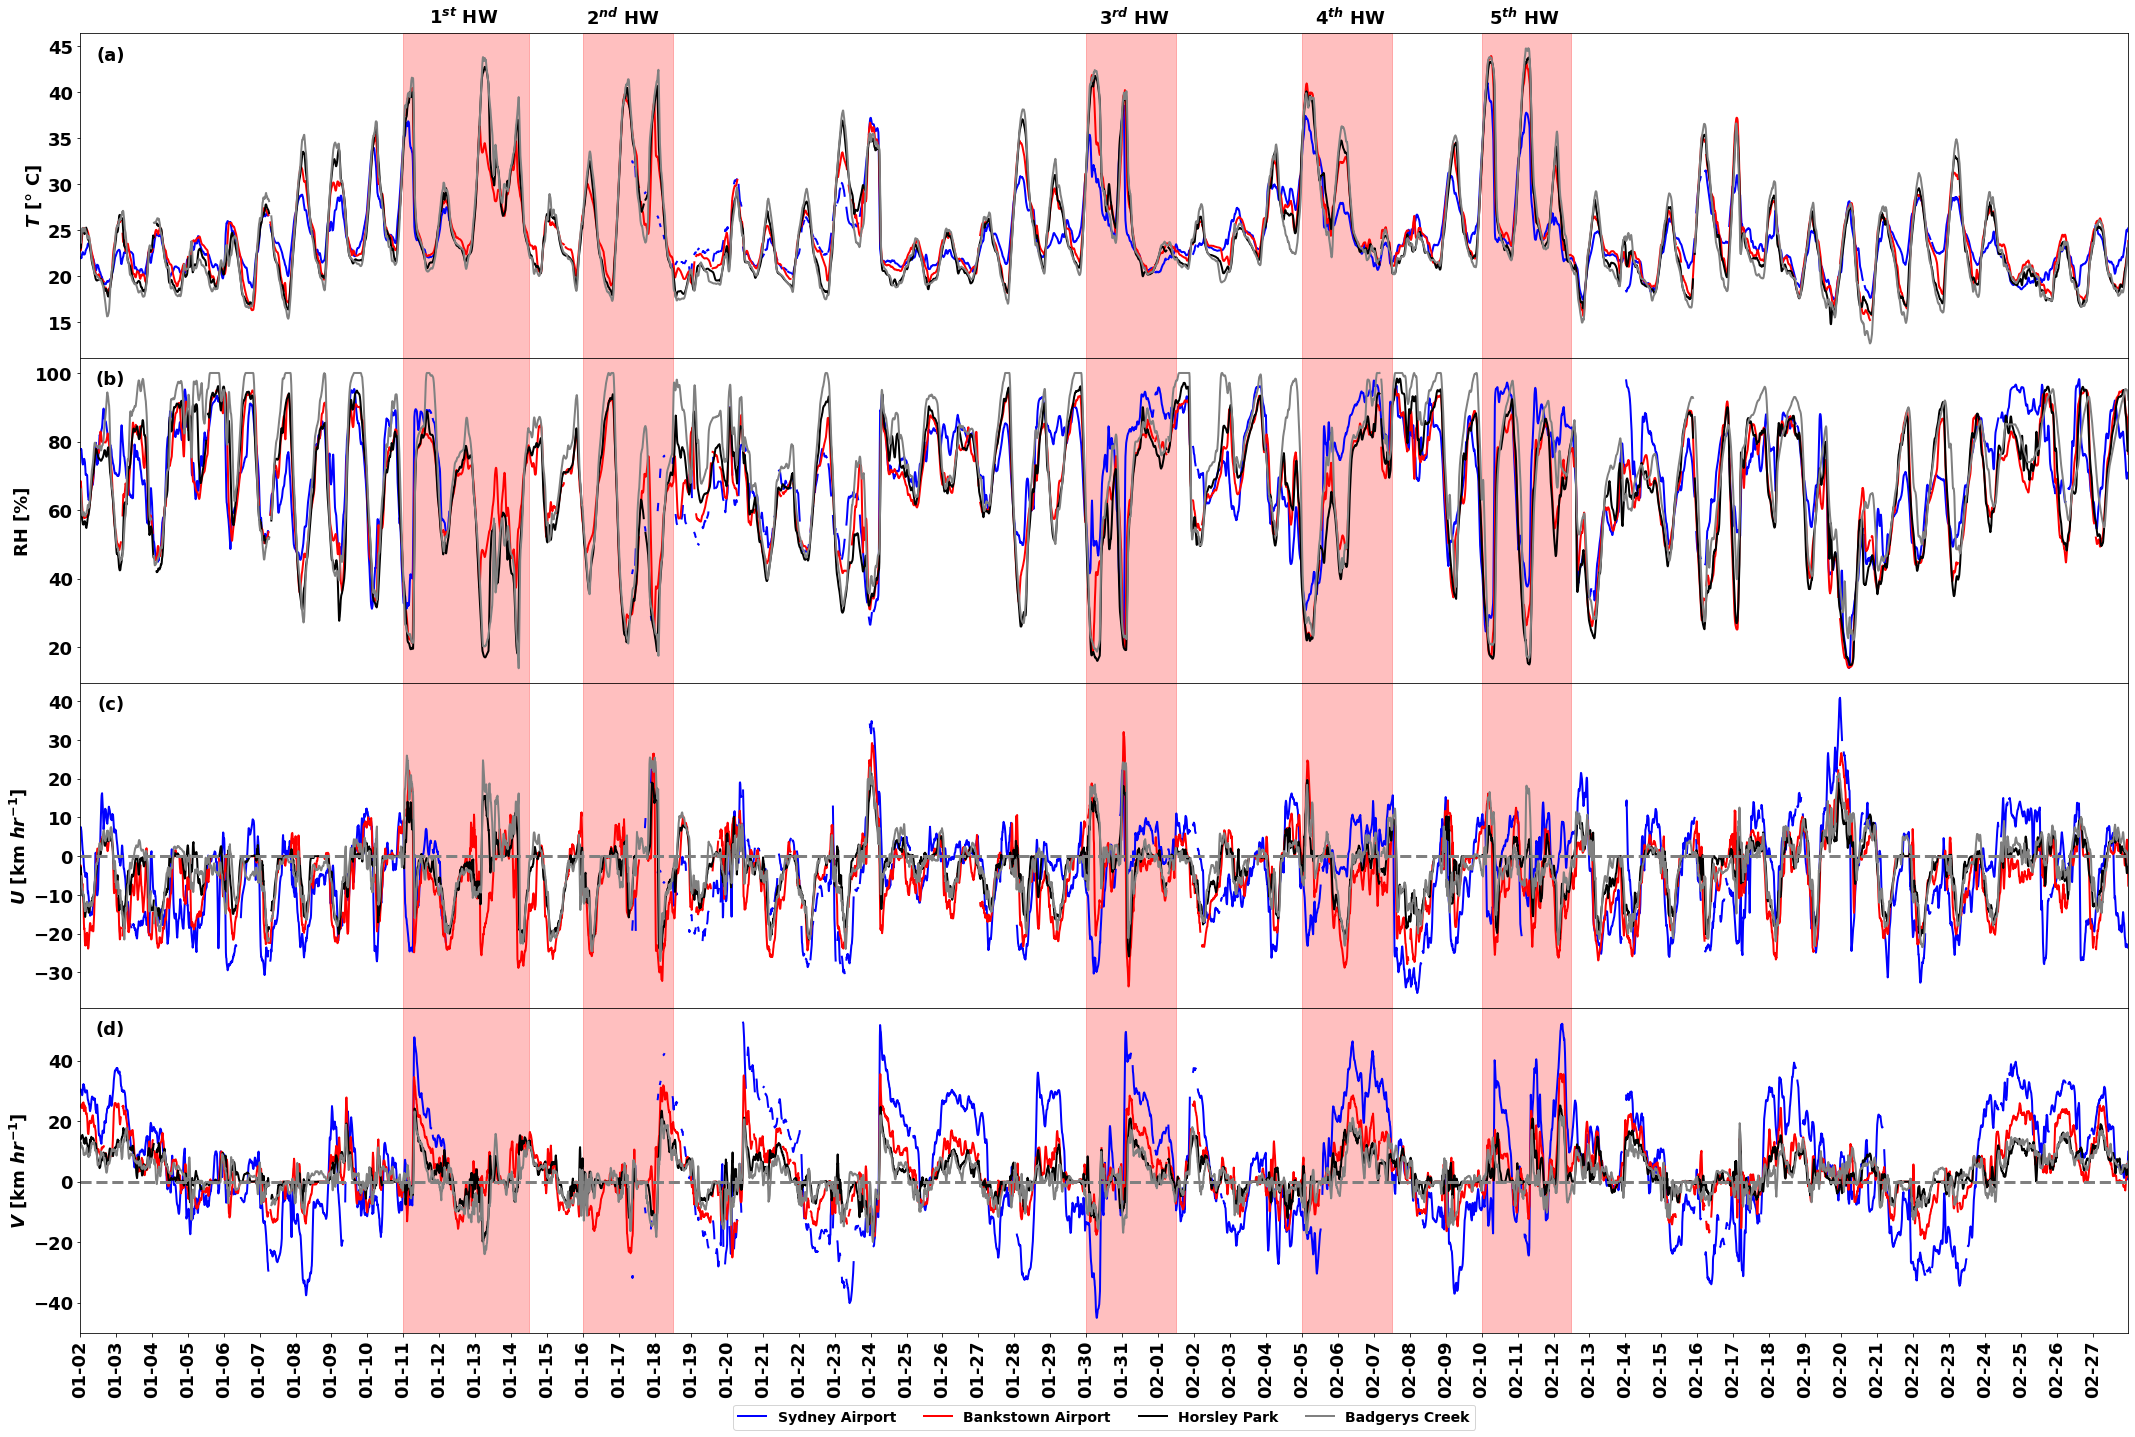

In [12]:
tind = [HW1S,HW1F,HW2S,HW2F,HW3S,HW3F,HW4S,HW4F,HW5S,HW5F]
vlabels = ['$T$ [\xb0 C]','RH [%]','$U$ [km $hr^{-1}$]','$V$ [km $hr^{-1}$]']
lspace = 144 # As the wrf output is saved at a 10 minute interval
figurename = 'AWS_Times_Series_SB_Foehn_Smooth.png'

datasmooth = np.empty((naws,4,nst),dtype=np.float64)

for nn in range(naws):
    datasmooth[nn,0,:] = smooth(odata[nn,0,:],window_len=6,window='flat')[:nst]
    datasmooth[nn,1,:] = smooth(odata[nn,1,:],window_len=6,window='flat')[:nst]
    datasmooth[nn,2,:] = smooth(odata[nn,2,:],window_len=6,window='flat')[:nst]
    datasmooth[nn,3,:] = smooth(odata[nn,3,:],window_len=6,window='flat')[:nst]

plot_ts(fdates[:-1],datasmooth,tind,vlabels,awsnm,figurename,lspace)

# Read in the previously extracted data

see plot_AWS_comparison.ipynb for code to extract the data

In [14]:
start = dt.datetime(syear,smon,sday,0,0,0)
end = dt.datetime(eyear,emon,eday,0,0,0)
days = (end - start).days
ntim = days * 24 * 60
datelist = [start + dt.timedelta(minutes=x) for x in range(ntim+1)]
# Get the day-month hour-minutes on 10 minute interval
ftimes = np.asarray([datelist[x].strftime("%m-%d %H-%M") for x in range(ntim+1)])[::10]

In [15]:
tsdata = np.empty((naws,nmem,4,len(ftimes)),dtype=np.float64)
# Loop through the ensemble members
for mm in range(nmem):

    # Loop through the sites
    for ss in range(naws):
    
        # Read data
        data = pd.read_csv('WRF_output_M%s_%s_AWS%s.txt' %(ensmem[mm],domain[mm],awsnum[ss]),delimiter = ' ')
        data.columns = ["PSFC", "T2", "TD2", "RH2", "PR", "WSPD", "WDIR","#"]
    
        tsdata[ss,mm,0,:] = data['T2'].iloc[0:len(ftimes)]
        tsdata[ss,mm,1,:] = data['RH2'].iloc[0:len(ftimes)]
        wspd = data['WSPD'].iloc[0:len(ftimes)]
        wdir = data['WDIR'].iloc[0:len(ftimes)]
        for tt in range(len(ftimes)):
            tsdata[ss,mm,2,tt] = (wspd[tt]*(-1)) * math.sin(math.radians(wdir[tt]))
            tsdata[ss,mm,3,tt] = (wspd[tt]*(-1)) * math.cos(math.radians(wdir[tt]))
    
        del data,wspd,wdir

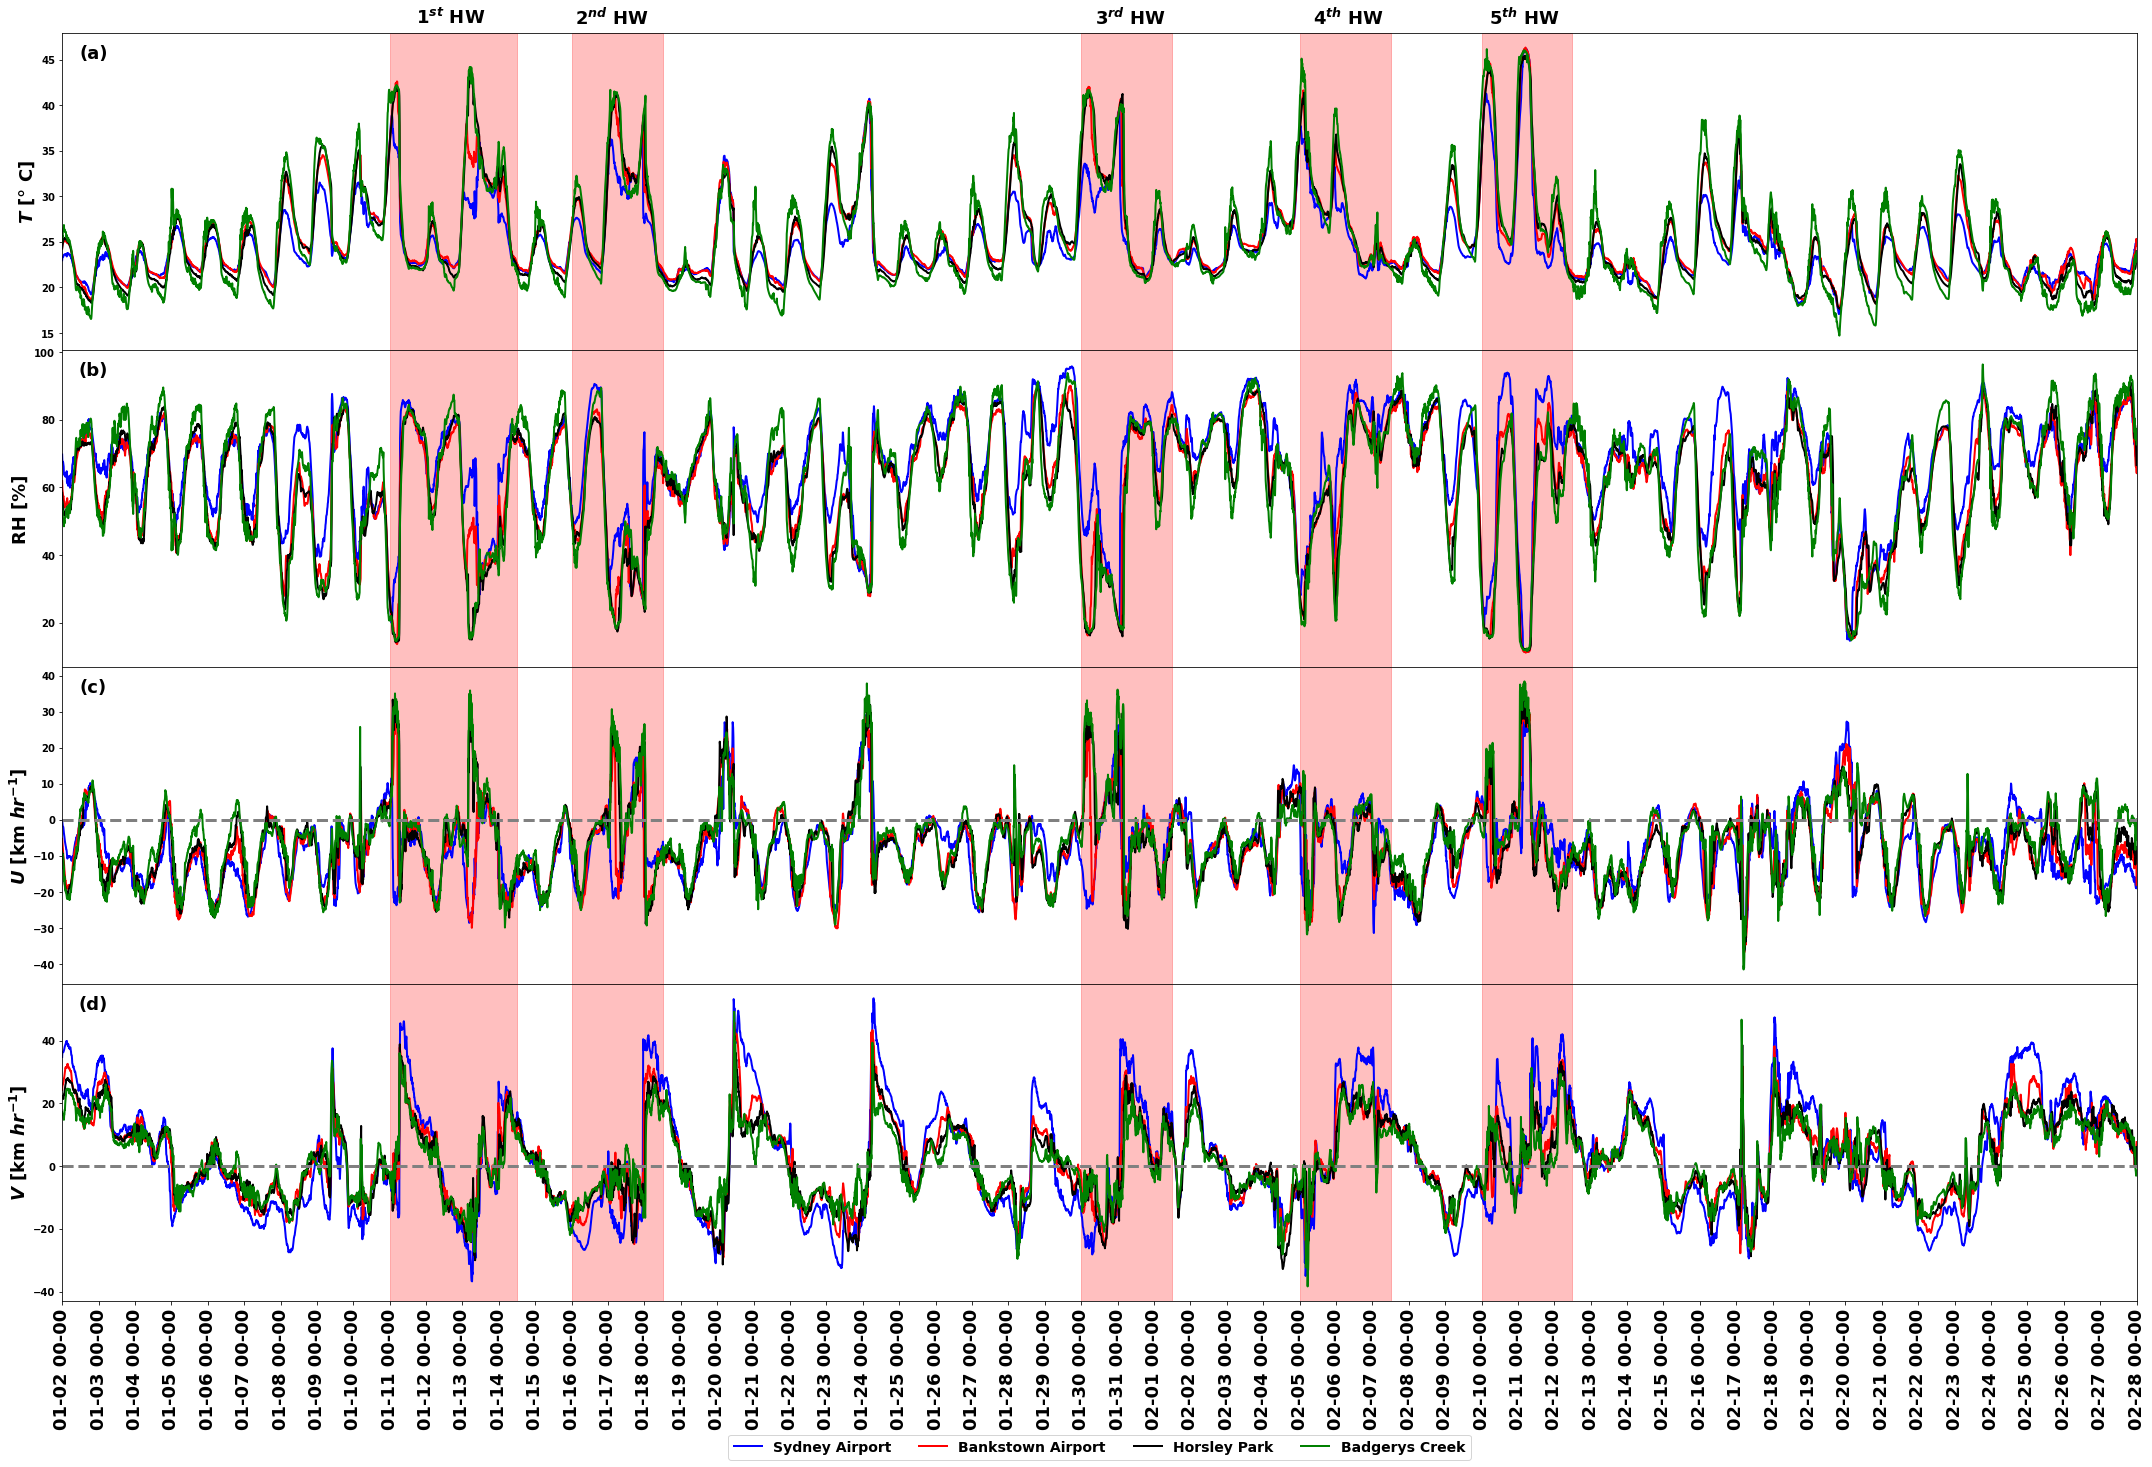

In [16]:
tind = [HW1S,HW1F,HW2S,HW2F,HW3S,HW3F,HW4S,HW4F,HW5S,HW5F]
vlabels = ['$T$ [\xb0 C]','RH [%]','$U$ [km $hr^{-1}$]','$V$ [km $hr^{-1}$]']
lspace = 144 # As the wrf output is saved at a 10 minute interval
figurename = 'WRF_Urban_Times_Series_SB_Foehn.png'

plot_ts(ftimes,np.nanmean(tsdata,axis=1),tind,vlabels,awsnm,figurename,lspace)

## Plot the non-urban data

In [17]:
gdata = np.empty((naws,nmem,4,len(ftimes)),dtype=np.float64)
# Loop through the ensemble members
for mm in range(nmem):

    # Loop through the sites
    for ss in range(naws):
    
        # Read data
        data = pd.read_csv('WRF_output_M%s_%s_AWS%s.txt' %(ensmem[mm],'d03',awsnum[ss]),delimiter = ' ')
        data.columns = ["PSFC", "T2", "TD2", "RH2", "PR", "WSPD", "WDIR","#"]
    
        gdata[ss,mm,0,:] = data['T2'].iloc[0:len(ftimes)]
        gdata[ss,mm,1,:] = data['RH2'].iloc[0:len(ftimes)]
        wspd = data['WSPD'].iloc[0:len(ftimes)]
        wdir = data['WDIR'].iloc[0:len(ftimes)]
        for tt in range(len(ftimes)):
            gdata[ss,mm,2,tt] = (wspd[tt]*(-1)) * math.sin(math.radians(wdir[tt]))
            gdata[ss,mm,3,tt] = (wspd[tt]*(-1)) * math.cos(math.radians(wdir[tt]))
    
        del data,wspd,wdir

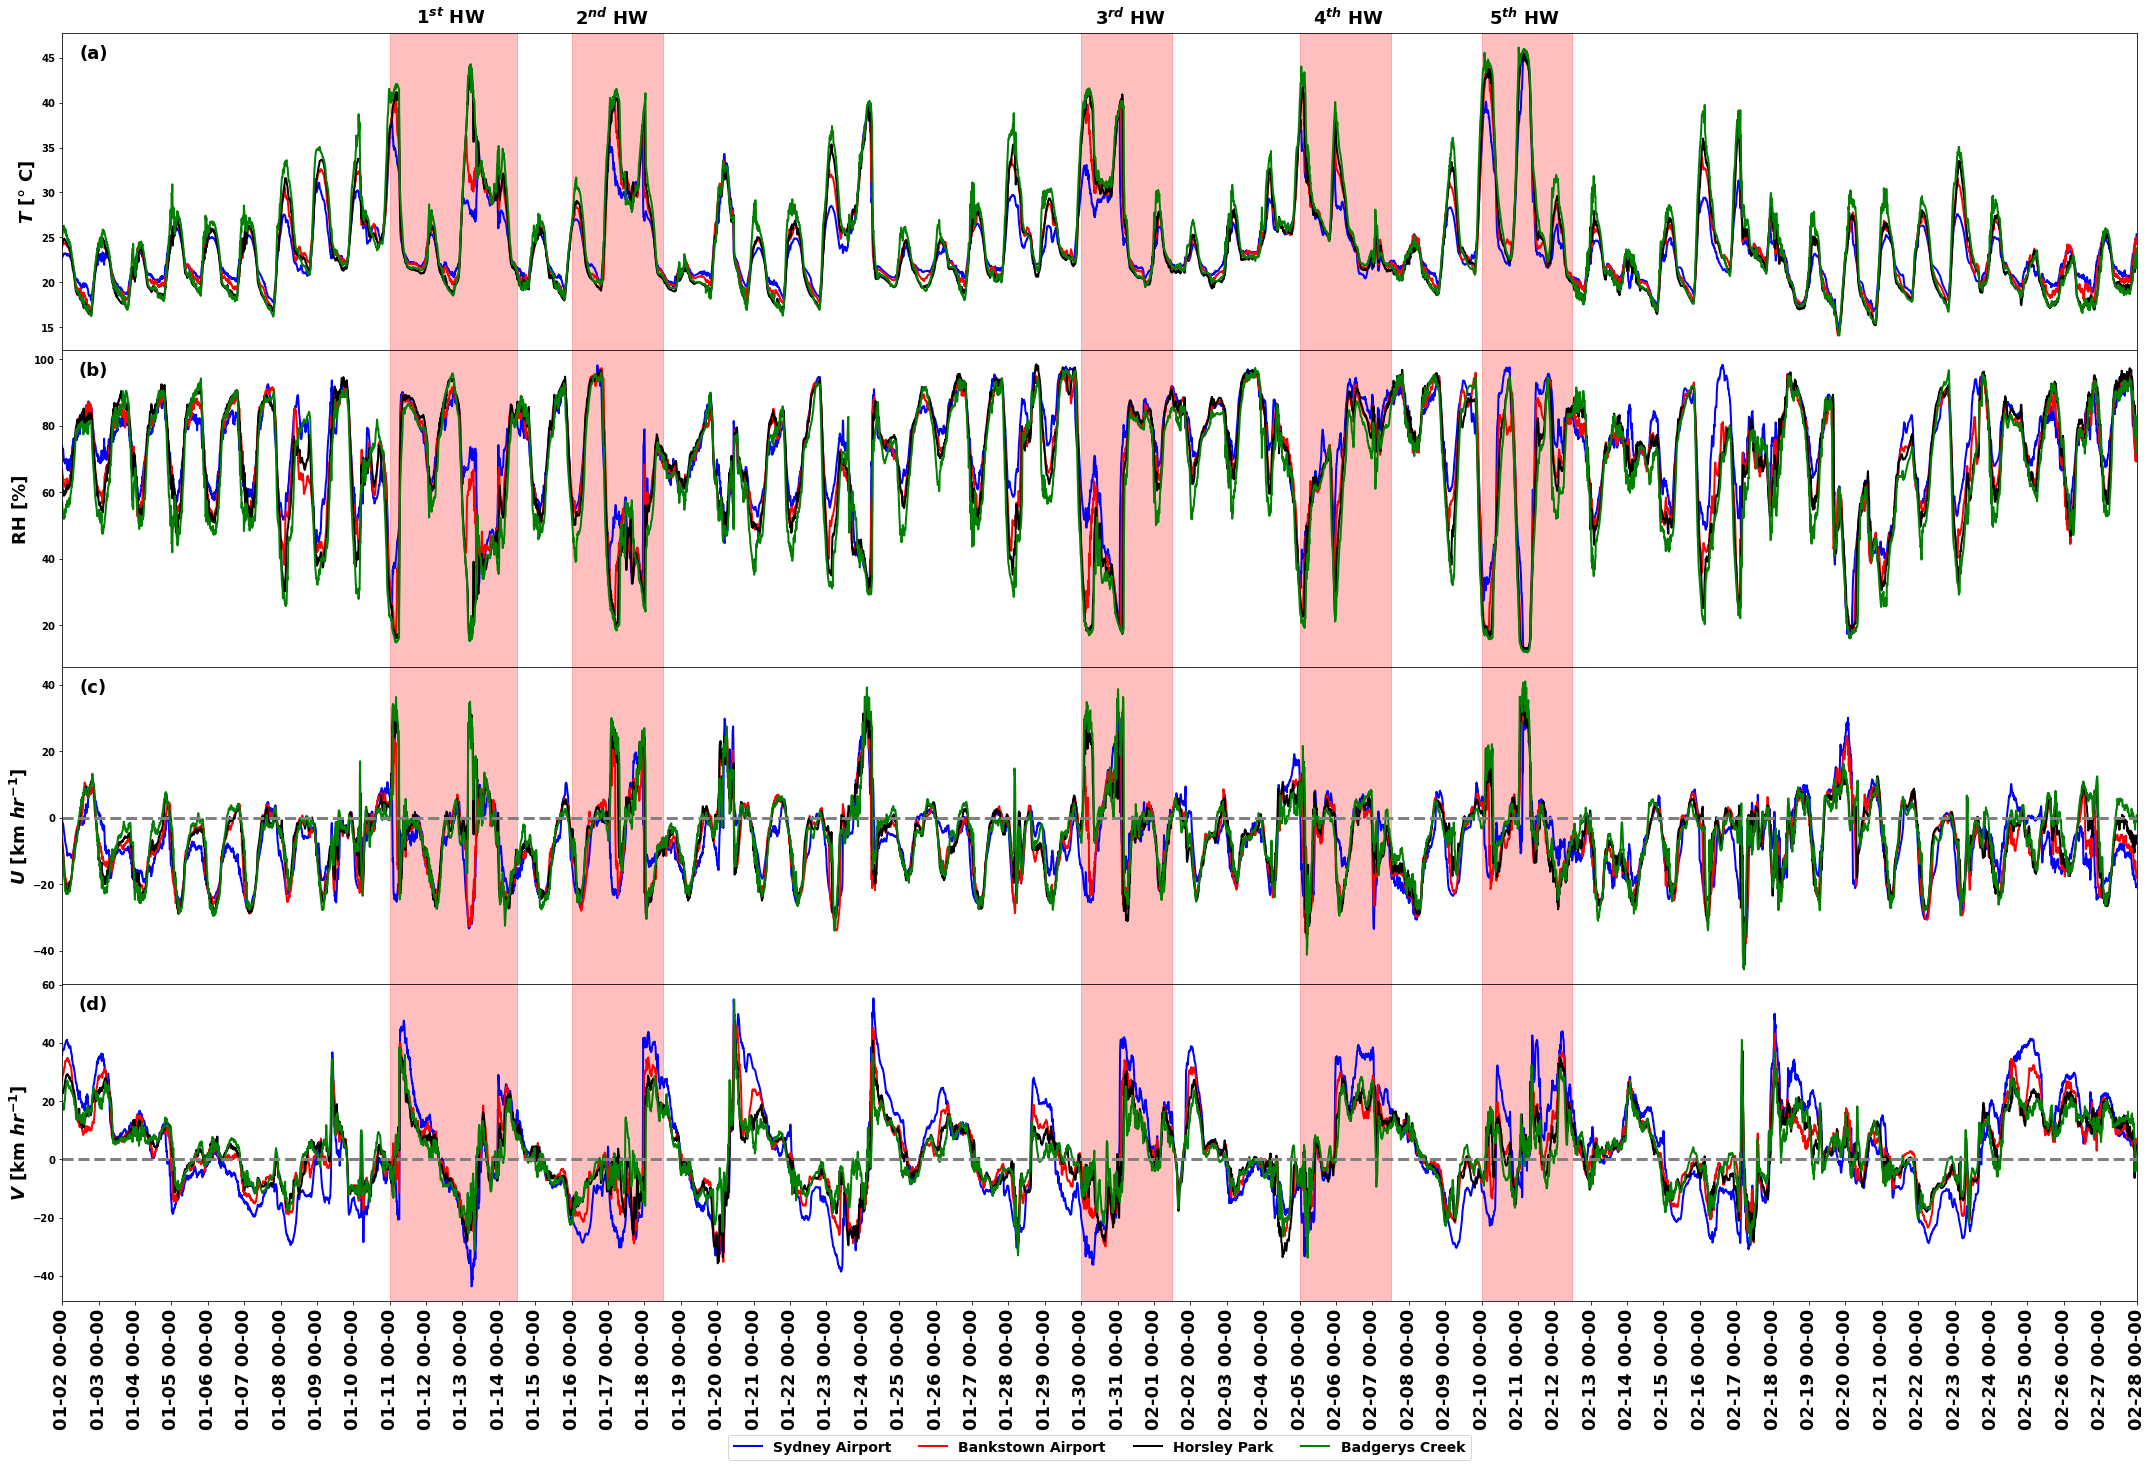

In [18]:
tind = [HW1S,HW1F,HW2S,HW2F,HW3S,HW3F,HW4S,HW4F,HW5S,HW5F]
vlabels = ['$T$ [\xb0 C]','RH [%]','$U$ [km $hr^{-1}$]','$V$ [km $hr^{-1}$]']
lspace = 144 # As the wrf output is saved at a 10 minute interval
figurename = 'WRF_Grass_Times_Series_SB_Foehn.png'

plot_ts(ftimes,np.nanmean(gdata,axis=1),tind,vlabels,awsnm,figurename,lspace)

## Contents of the AWS file
    1  hd
    2  Station Number
#### datetime format in Local time
    3  YYYY
    4  MM 
    5  DD
    6  HH24
    7  MI
#### datetime format in Local standard time
    8  YYYY
    9  MM 
    10 DD
    11 HH24
    12 MI
#### datetime format in Universal coordinated time
    13 YYYY
    14 MM 
    15 DD
    16 HH24
    17 MI
#### variables
    18 Precipitation since last (AWS) observation in mm
    19 Quality of precipitation since last (AWS) observation value
    20 Period over which precipitation since last (AWS) observation is measured in minutes
    21 Air Temperature in degrees Celsius
    22 Quality of air temperature
    23 Wet bulb temperature in degrees Celsius
    24 Quality of Wet bulb temperature
    25 Dew point temperature in degrees Celsius
    26 Quality of dew point temperature
    27 Relative humidity in percentage %
    28 Quality of relative humidity
    29 Vapour pressure in hPa
    30 Quality of vapour pressure
    31 Saturated vapour pressure in hPa
    32 Quality of saturated vapour pressure
    33 Wind (1 minute) speed in km/h,
    34 Wind (1 minute) speed quality
    35 Wind (1 minute) direction in degrees true
    36 Wind (1 minute) direction quality
    37 Standard deviation of wind (1 minute) 
    38 Standard deviation of wind (1 minute) direction quality
    39 Maximum wind gust (over 1 minute) in km/h
    40 Maximum wind gust (over 1 minute) quality
    41 Visibility (automatic - one minute data) in km
    42 Quality of visibility (automatic - one minute data) 
    43 Mean sea level pressure in hPa
    44 Quality of mean sea level pressure
